In [22]:
import pandas as pd
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import keras
import tensorflow as tf
print(keras.__version__)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

3.11.3


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# it won't use gpus

Num GPUs Available:  0


2025-10-28 13:57:20.493766: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [2]:
# load data
data_WT = pd.read_csv('data_WT.csv')

In [23]:
X_rna = data_WT['mean_WT_RNA'].values.astype('float32').reshape(-1, 1)
X_chip = data_WT[['mean_WT_H3K27ac', 'mean_WT_H2BK120ac', 'mean_WT_H3K4me1']].values.astype('float32')
y_atac = data_WT['ATAC_SKUT1_averaged'].values.astype('float32').reshape(-1,1)

print(X_rna.shape, X_chip.shape, y_atac.shape)

# scale data
X_rna = np.log1p(X_rna)
X_chip = np.log1p(X_chip)
y_atac = np.log1p(y_atac)


rna_scaler = StandardScaler()
chip_scaler = StandardScaler()
atac_scaler = StandardScaler()

X_rna = rna_scaler.fit_transform(X_rna)
X_chip = chip_scaler.fit_transform(X_chip)
y_atac = atac_scaler.fit_transform(y_atac)

(28611253, 1) (28611253, 3) (28611253, 1)


In [25]:
# shape
n_rna = X_rna.shape[1]
n_chip = X_chip.shape[1]

# RNA branch
input_rna = Input(shape=(n_rna,), name='rna_input')
r = Dense(64, activation='relu')(input_rna)
r = BatchNormalization()(r)
r = Dropout(0.3)(r)
r = Dense(32, activation='relu')(r)

# ChIP branch
input_chip = Input(shape=(n_chip,), name='chip_input')
c = Dense(128, activation='relu')(input_chip)
c = BatchNormalization()(c)
c = Dropout(0.3)(c)
c = Dense(64, activation='relu')(c)

# Fuse branches
x = Concatenate()([r, c])
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='linear', name='atac_output')(x)

model = Model(inputs=[input_rna, input_chip], outputs=output)
model.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae']) # Adam(1e-4), the number modulates the learning rate
model.summary()


# split data
X_rna_train, X_rna_val, X_chip_train, X_chip_val, y_train, y_val = train_test_split(
    X_rna, X_chip, y_atac, test_size=0.2, random_state=42
)

checkpoint = ModelCheckpoint(
    "best_model.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False
)

subset = 1000
model.fit(
    {'rna_input': X_rna[:subset], 'chip_input': X_chip[:subset]},
    y_train[:subset],
    epochs=100,
    batch_size=32,
    verbose=0
)

# # train model
# history = model.fit(
#     {'rna_input': X_rna_train, 'chip_input': X_chip_train},
#     y_train,
#     validation_data=(
#         {'rna_input': X_rna_val, 'chip_input': X_chip_val},
#         y_val
#     ),
#     batch_size=256,
#     epochs=10,
#     # epochs=50,
#     verbose=1,
#     callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss')]
# )



Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ rna_input           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ chip_input          │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 64)        │        128 │ rna_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 128)       │        512 │ chip_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_30[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_32[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 32)        │      2,080 │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 64)        │      8,256 │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 96)        │          0 │ dense_31[0][0],   │
│ (Concatenate)       │                   │            │ dense_33[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 64)        │      6,208 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 64)        │          0 │ dense_34[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ atac_output (Dense) │ (None, 1)         │         65 │ dropout_20[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,017 (70.38 KB)

 Trainable params: 17,633 (68.88 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/10
89411/89411 ━━━━━━━━━━━━━━━━━━━━ 177s 2ms/step - loss: 0.6390 - mae: 0.5784 - val_loss: 0.6277 - val_mae: 0.5792
Epoch 2/10
89411/89411 ━━━━━━━━━━━━━━━━━━━━ 174s 2ms/step - loss: 0.6346 - mae: 0.5770 - val_loss: 0.6281 - val_mae: 0.5753
Epoch 3/10
89411/89411 ━━━━━━━━━━━━━━━━━━━━ 175s 2ms/step - loss: 0.6340 - mae: 0.5768 - val_loss: 0.6257 - val_mae: 0.5729
Epoch 4/10
89411/89411 ━━━━━━━━━━━━━━━━━━━━ 175s 2ms/step - loss: 0.6337 - mae: 0.5766 - val_loss: 0.6266 - val_mae: 0.5751
Epoch 5/10
89411/89411 ━━━━━━━━━━━━━━━━━━━━ 177s 2ms/step - loss: 0.6335 - mae: 0.5766 - val_loss: 0.6267 - val_mae: 0.5771
Epoch 6/10
89411/89411 ━━━━━━━━━━━━━━━━━━━━ 178s 2ms/step - loss: 0.6334 - mae: 0.5765 - val_loss: 0.6279 - val_mae: 0.5749
Epoch 7/10
89411/89411 ━━━━━━━━━━━━━━━━━━━━ 185s 2ms/step - loss: 0.6332 - mae: 0.5765 - val_loss: 0.6273 - val_mae: 0.5756
Epoch 8/10
89411/89411 ━━━━━━━━━━━━━━━━━━━━ 176s 2ms/step - loss: 0.6331 - mae: 0.5764 - val_loss: 0.6262 - val_mae: 0.5727
Epoch 9/

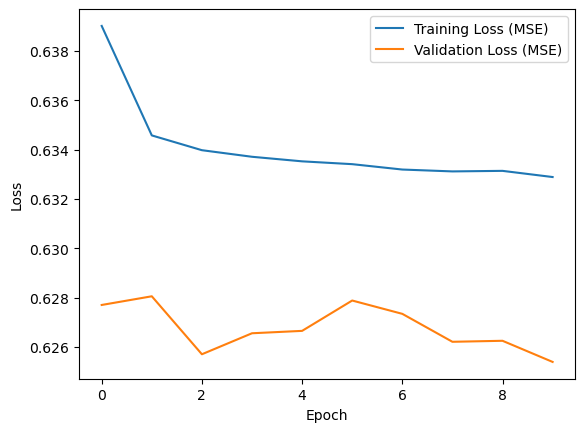

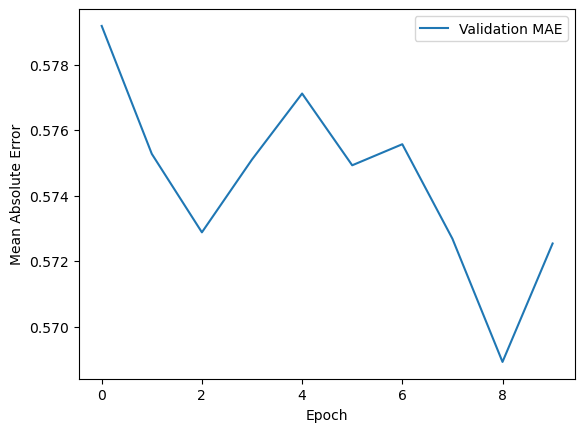

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()